In [1]:
import numpy as np
from grid import Grid

g = Grid()
g.print()

-------------------------------
| 0,0 | 1,0 | 2,0 | 3,0 | 4,0 | 
-------------------------------
| 0,1 | 1,1 | 2,1 | 3,1 | 4,1 | 
-------------------------------
| 0,2 | 1,2 | 2,2 | 3,2 | 4,2 | 
-------------------------------
| 0,3 | 1,3 | 2,3 | 3,3 | 4,3 | 
-------------------------------
| 0,4 | 1,4 | 2,4 | 3,4 | 4,4 | 
-------------------------------


In [2]:
e_star = 0.3

# Q-Learning

In [3]:
from actors import QLearning

q = QLearning(g)
q.run(epsilon=e_star)

print('Steps:', q.steps)
print('Rewards:', q.totalReward)

Steps: 198
Rewards: -20


In [4]:
for episodes in range(2000):
    q.resetCount()
    q.run(epsilon=e_star)

print('Episodes:', episodes)
print('Steps:', q.steps)
print('Rewards:', q.totalReward)

Episodes: 1999
Steps: 10
Rewards: 8


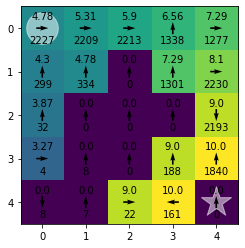

In [5]:
q.plot()

# $\mathcal{L}$($\pi_i$|$\xi$)

In [99]:
def generatePi(agent, e=0.1):
    # if not(0 < e < 1):
    #     return -np.inf
    p_a = lambda a, s: (e/4, 1-e+e/4)[a == max(agent.Q[s], key=agent.Q[s].get)] if 0 < e < 1 else 1e-10
    pi = np.array([[p_a(a, s) for a in agent.g.ACTIONS] for s in agent.g.S])
    return pi.reshape(agent.g.size[0], agent.g.size[1], len(agent.g.ACTIONS), order='F')

pi_star = generatePi(q, e_star)
pi_star

array([[[0.075, 0.075, 0.775, 0.075],
        [0.775, 0.075, 0.075, 0.075],
        [0.775, 0.075, 0.075, 0.075],
        [0.075, 0.075, 0.775, 0.075],
        [0.075, 0.775, 0.075, 0.075]],

       [[0.075, 0.075, 0.775, 0.075],
        [0.775, 0.075, 0.075, 0.075],
        [0.775, 0.075, 0.075, 0.075],
        [0.775, 0.075, 0.075, 0.075],
        [0.775, 0.075, 0.075, 0.075]],

       [[0.075, 0.075, 0.775, 0.075],
        [0.775, 0.075, 0.075, 0.075],
        [0.775, 0.075, 0.075, 0.075],
        [0.775, 0.075, 0.075, 0.075],
        [0.075, 0.075, 0.775, 0.075]],

       [[0.775, 0.075, 0.075, 0.075],
        [0.775, 0.075, 0.075, 0.075],
        [0.775, 0.075, 0.075, 0.075],
        [0.775, 0.075, 0.075, 0.075],
        [0.075, 0.075, 0.075, 0.775]],

       [[0.075, 0.075, 0.775, 0.075],
        [0.075, 0.075, 0.775, 0.075],
        [0.075, 0.775, 0.075, 0.075],
        [0.775, 0.075, 0.075, 0.075],
        [0.775, 0.075, 0.075, 0.075]]])

<AxesSubplot: >

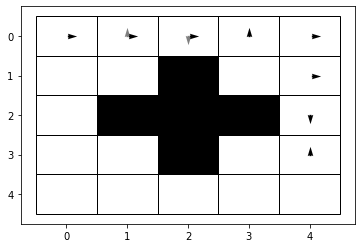

In [7]:
from plot import plotTrajectory
plotTrajectory(q.getTrajectory(), q.g)

## Teste de Sanidade

In [8]:
es = [0.9, 0.7, 0.5] + [e_star] # e_star = 0.3

pis = [generatePi(q, e) for e in es] 
def likelihood(pi, e):
    arr = [np.log(pi[x,y][a]) for (x,y), a in e]
    return np.sum(arr)

likes = [likelihood(pi, q.getTrajectory(2)) for pi in pis]
p = np.argmax(likes)
print(f'Maior: {p}\n', likes)

Maior: 3
 [-11.974750526774631, -9.441462409697213, -7.918912117325556, -7.219672327921975]


### Certeza? 

In [9]:
es = [0.9, 0.1, 0.5] + [e_star] # e_star = 0.3
pis = [generatePi(q, e) for e in es]

likes = [likelihood(pi, q.getTrajectory(2)) for pi in pis]
p = np.argmax(likes)

print(f'Maior: {p}\n', likes)

Maior: 3
 [-11.974750526774631, -8.001451239985567, -7.918912117325556, -7.219672327921975]


<AxesSubplot: >

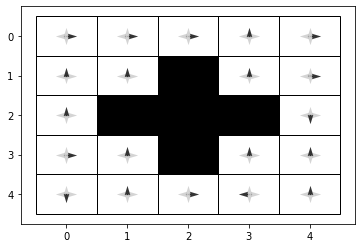

In [10]:
from plot import plotPolicy
plotPolicy(pis[p], q.g)

### Com muitas trajetórias:

In [11]:
from actors import QLearning

agent = QLearning(g)
es = [0.9, 0.1, 0.5]+[e_star] # e_star = 0.3

def teste():
    agent.resetCount()
    agent.run(epsilon=e_star)

    pis = [generatePi(agent, e) for e in es] 
    likes = np.array([likelihood(pi, q.getTrajectory(2)) for pi in pis])
    return likes


total_episodes = 1000
exps = [teste() for _ in range(total_episodes)]
freq = [np.mean([int(np.argmax(v)==i) for v in exps])for i in range(len(es))]
print(np.argmax(np.sum(exps, axis=0)))
print(np.sum(exps, axis=0))
# print(freq)


3
[-12250.54411187 -10709.63967447  -9125.99055165  -8971.20351478]
[0.004, 0.0, 0.632, 0.364]


## Gradiente Descendente

In [157]:
import random 

def gradient(pi,q):
    arr = [1/pi[x,y,a] for (x,y),a in q.getTrajectory(2)]
    return np.sum(arr)

def GradientDescent(agent, param=None, learning_rate=.01, decay=.2, precision=1e-4, max_trials=10000):
    if param is None:
        param = random.random()

    error = 1+precision
    trials = 0

    pi = generatePi(agent, param)
    l = likelihood(pi, agent.getTrajectory(2))
    while (error > precision) and (trials <= max_trials):
        trials += 1
        new_param = param + learning_rate * gradient(pi, agent)
        new_pi = generatePi(agent, new_param)
        new_l = likelihood(new_pi, agent.getTrajectory(2))
        error = np.abs(new_l - l)
        if new_l >= l:
            # learning_rate += (learning_rate * 0.2) 
            learning_rate += learning_rate / (1+decay*trials)
            pi = new_pi
            l = new_l
            param = new_param
        else:
            # learning_rate -= (learning_rate * 0.2)
            learning_rate -= learning_rate / (1+decay*trials)
            
    return param, trials, error
 
GradientDescent(q)

(0.7334582620485892, 19, 9.045451287192918e-05)

In [176]:
gradient(generatePi(agent, 0.05), agent)

88.3116883116883

In [167]:
GradientDescent(q, param=.95, decay=.8)

(0.95, 8119, 9.99894574373883e-05)

In [158]:
GradientDescent(q, param=.05, decay=.2)

(0.3305194805194806, 20, 9.478093899950579e-05)

In [56]:
np.mean([GradientDescent(q) for _ in range(100)], axis=0)

C:\Users\guilherme.albarrans\AppData\Local\Temp\ipykernel_19340\1671513946.py:5: RuntimeWarning: invalid value encountered in log
  arr = [np.log(pi[x,y][a]) for (x,y), a in e]


array([  0.55955915, 179.33      ,          nan])

In [ ]:
from actors import QLearning

agent = QLearning(g)
es = [0.9, 0.1, 0.5]+[e_star] # e_star = 0.3

def teste():
    agent.resetCount()
    agent.run(epsilon=e_star)

    pis = [generatePi(agent, e) for e in es] 
    likes = np.array([likelihood(pi, q.getTrajectory(2)) for pi in pis])
    return likes


total_episodes = 1000
exps = [teste() for _ in range(total_episodes)]
freq = [np.mean([int(np.argmax(v)==i) for v in exps])for i in range(len(es))]
print(np.argmax(np.sum(exps, axis=0)))
print(np.sum(exps, axis=0))
# print(freq)
